# Sentiment Analysis

In [ ]:
import pandas as pd
import numpy as np
import re
import spacy
import time

from numpy import asarray
from numpy import zeros
from nltk.corpus import stopwords
from nltk import word_tokenize

from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Dense, Flatten, Embedding, Masking, Bidirectional

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [ ]:
reviews_df = pd.read_csv('IMDB Dataset.csv')

In [ ]:
reviews_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# convert sentiment into binary labels
reviews_df['label'] = pd.get_dummies(reviews_df["sentiment"])['positive']
reviews_df.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [ ]:
# check class balance
reviews_df['label'].mean()

0.5

In [ ]:
# Preprocessing
# Function that removes characters
def replace(replacements):
    for replace in replacements: 
        reviews_df['review'] = reviews_df['review'].str.replace(replace, '', case = False)

# remove unnecessary characters
replace(['/><br', '<br', "\"", "\'", "/", '=',
         '<', '>', ',', '_', '\n', '\.', '-', '\n', '\(', '\)'])

In [ ]:
potential_duplicates = 'abcdefghijklmnopqrstuvwxyz!?'

# Loops through the alphabet and replaces charaters that appear 3+ times in a row with one occurence
for i in potential_duplicates: 
    if i == '?':
        i = '\?'
    reviews_df['review'] = reviews_df.review.apply(lambda x: re.sub(i + i + i + '+', i, x))

In [ ]:
# import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

In [ ]:
# lemmatization

# using nltk
# # reference: https://gaurav5430.medium.com/using-nltk-for-lemmatizing-sentences-c1bfff963258
# #import nltk
# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import wordnet

# lemmatizer = WordNetLemmatizer()

# # function to convert nltk tag to wordnet tag
# def nltk_tag_to_wordnet_tag(nltk_tag):
#     if nltk_tag.startswith('J'):
#         return wordnet.ADJ
#     elif nltk_tag.startswith('V'):
#         return wordnet.VERB
#     elif nltk_tag.startswith('N'):
#         return wordnet.NOUN
#     elif nltk_tag.startswith('R'):
#         return wordnet.ADV
#     else:          
#         return None

    
# def lemmatize_sentence(sentence):
#     #tokenize the sentence and find the POS tag for each token
#     nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
#     #tuple of (token, wordnet_tag)
#     wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
#     lemmatized_sentence = []
#     for word, tag in wordnet_tagged:
#         if tag is None:
#             #if there is no available tag, append the token as is
#             lemmatized_sentence.append(word)
#         else:   
#             #else use the tag to lemmatize the token
#             lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
#     return ' '.join(lemmatized_sentence)

# docs = reviews_df['review'].apply(lemmatize_sentence)

In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 913 kB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=fc01c341b4be81891f8edab60dabd965765446210a280f80949ce5dc23dbd797
  Stored in directory: /tmp/pip-ephem-wheel-cache-xoh07k9j/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
import en_core_web_lg
nlp = en_core_web_lg.load(disable=['ner', 'parser'])

In [ ]:
# Lemmatization
reviews_df['review'] = reviews_df['review'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# remove stopwords
stop_words = list(stopwords.words('english'))
reviews_df['review'] = reviews_df['review'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))

In [ ]:
# Tokenize text
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(reviews_df['review'])

## Use Kera to train embeddings

In [ ]:
# Taken from Spring 2021 Class Notes
from typing import List
def integer_encode_documents(docs: List[str], tokenizer: Tokenizer)-> List[List[int]]:
    documents = []
    for d in docs:
        doc_integers = []
        for i in text_to_word_sequence(d):
            doc_integers.append(tokenizer.word_index[i])
        documents.append(doc_integers)
    return documents

def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

def get_max_token_length_per_doc(docs: List[List[str]])-> int:
    return max(list(map(lambda x: len(x.split()), docs)))

In [ ]:
encoded_docs = integer_encode_documents(reviews_df['review'], tokenizer)

In [ ]:
# check doc lengths
get_max_token_length_per_doc(reviews_df['review'], tokenizer)

1528

(array([3.6546e+04, 1.0057e+04, 2.4580e+03, 8.7900e+02, 4.5000e+01,
        6.0000e+00, 5.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([   3. ,  155.5,  308. ,  460.5,  613. ,  765.5,  918. , 1070.5,
        1223. , 1375.5, 1528. ]),
 <a list of 10 Patch objects>)

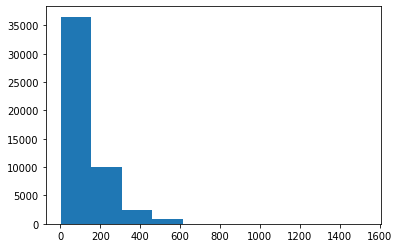

In [ ]:
import matplotlib.pyplot as plt

plt.hist(list(map(lambda doc: len(doc), encoded_docs)))

In [ ]:
# Pad documents to the same length
MAX_SEQUENCE_LENGTH = 400

padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [ ]:
VOCAB_SIZE = 10000  # VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)
EMBEDDING_SIZE = 300

# define the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBEDDING_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Flatten()) 
model.add(Dense(1, activation='sigmoid')) 

In [ ]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 300)          3000000   
                                                                 
 flatten (Flatten)           (None, 120000)            0         
                                                                 
 dense (Dense)               (None, 1)                 120001    
                                                                 
Total params: 3,120,001
Trainable params: 3,120,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# split data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, reviews_df['label'], test_size=0.1)

In [ ]:
# fit the model
model.fit(X_train, y_train, epochs=5, verbose=1)

Epoch 1/5
1407/1407 [==============================] - 16s 11ms/step - loss: 0.0521 - acc: 0.9861
Epoch 2/5
1407/1407 [==============================] - 15s 11ms/step - loss: 0.0080 - acc: 0.9992
Epoch 3/5
1407/1407 [==============================] - 13s 9ms/step - loss: 0.0017 - acc: 1.0000
Epoch 4/5
1407/1407 [==============================] - 11s 8ms/step - loss: 6.1253e-04 - acc: 1.0000
Epoch 5/5
1407/1407 [==============================] - 11s 8ms/step - loss: 2.6051e-04 - acc: 1.0000


In [ ]:
# baseline accuracy
y_test.mean()

0.507

In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

157/157 [==============================] - 1s 3ms/step - loss: 0.4730 - acc: 0.8848
Accuracy: 88.480002


In [ ]:
predictions = [i[0] for i in (model.predict(X_test) > 0.5).astype("int32")]
# Prints evaluation metrics
print('Accuracy: ', round(np.mean(predictions == y_test) * 100, 3))
print('ROC_AUC: ', round(roc_auc_score(y_test, predictions) * 100, 3))
print()
confusion_matrix(y_test, predictions)

Accuracy:  88.48
ROC_AUC:  88.464



array([[2152,  313],
       [ 263, 2272]])

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2465
           1       0.88      0.90      0.89      2535

    accuracy                           0.88      5000
   macro avg       0.89      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



## RNN & LSTM

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoded_labels = to_categorical(encoder.fit_transform(reviews_df['sentiment']))

# split data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, encoded_labels, test_size=0.2)

### using self-trained embeddings

In [ ]:
# define model

def make_binary_classification_rnn_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, EMBEDDING_SIZE, input_length=MAX_SEQUENCE_LENGTH))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(SimpleRNN(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

def make_lstm_classification_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, EMBEDDING_SIZE, input_length=MAX_SEQUENCE_LENGTH))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH))) #unites = 32/64/128
    model.add(Dense(16))
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [ ]:
model_rnn = make_binary_classification_rnn_model()
print(model_rnn)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 400, 300)          3000000   
                                                                 
 masking_1 (Masking)         (None, 400, 300)          0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                23360     
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
 dense_4 (Dense)             (None, 2)                 34        
                                                                 
Total params: 3,024,434
Trainable params: 3,024,434
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model
history = model_rnn.fit(X_train, y_train,validation_split = 0.1, epochs=10, verbose=1)

Epoch 1/10
1125/1125 [==============================] - 514s 455ms/step - loss: 0.7008 - accuracy: 0.4995 - val_loss: 0.7079 - val_accuracy: 0.4857
Epoch 2/10
1125/1125 [==============================] - 518s 461ms/step - loss: 0.6958 - accuracy: 0.5103 - val_loss: 0.6942 - val_accuracy: 0.4927
Epoch 3/10
1125/1125 [==============================] - 522s 464ms/step - loss: 0.6922 - accuracy: 0.5099 - val_loss: 0.7002 - val_accuracy: 0.4938
Epoch 4/10
1125/1125 [==============================] - 518s 460ms/step - loss: 0.6873 - accuracy: 0.5173 - val_loss: 0.6998 - val_accuracy: 0.5128
Epoch 5/10
1125/1125 [==============================] - 520s 462ms/step - loss: 0.6894 - accuracy: 0.5110 - val_loss: 0.7074 - val_accuracy: 0.4848
Epoch 6/10
1125/1125 [==============================] - 518s 461ms/step - loss: 0.6864 - accuracy: 0.5100 - val_loss: 0.7028 - val_accuracy: 0.4840
Epoch 7/10
1125/1125 [==============================] - 519s 462ms/step - loss: 0.6830 - accuracy: 0.5186 - val_

In [ ]:
# evaluate the model
loss, accuracy = model_rnn.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

313/313 [==============================] - 19s 58ms/step - loss: 0.7020 - accuracy: 0.4912
Accuracy: 49.120000


In [ ]:
# LSTM
model_lstm = make_lstm_classification_model()
print(model_lstm)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 400, 300)          18555600  
                                                                 
 masking_1 (Masking)         (None, 400, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 2)                 34        
                                                                 
Total params: 18,650,114
Trainable params: 18,650,114
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model
history = model_lstm.fit(X_train, y_train,validation_split = 0.1, epochs=10, verbose=1)

Epoch 1/10
225/225 [==============================] - 222s 978ms/step - loss: 0.6939 - accuracy: 0.4965 - val_loss: 0.6942 - val_accuracy: 0.4812
Epoch 2/10
183/225 [=======================>......] - ETA: 40s - loss: 0.6932 - accuracy: 0.4990

KeyboardInterrupt: ignored

In [ ]:
# evaluate the model
loss, accuracy = model_lstm.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

I am not sure why LSTM&RNN using self-trained embeddings perform so badly.

### Using Glove embeddings

In [ ]:
!wget https://dso-560-nlp-text-analytics.s3.amazonaws.com/glove6b100dtxt.zip
!unzip glove6b100dtxt.zip 

--2021-12-15 22:35:47--  https://dso-560-nlp-text-analytics.s3.amazonaws.com/glove6b100dtxt.zip
Resolving dso-560-nlp-text-analytics.s3.amazonaws.com (dso-560-nlp-text-analytics.s3.amazonaws.com)... 52.216.147.156
Connecting to dso-560-nlp-text-analytics.s3.amazonaws.com (dso-560-nlp-text-analytics.s3.amazonaws.com)|52.216.147.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137847651 (131M) [application/zip]
Saving to: ‘glove6b100dtxt.zip.1’

glove6b100dtxt.zip. 100%[===================>] 131.46M  42.2MB/s    in 3.1s    

2021-12-15 22:35:50 (42.2 MB/s) - ‘glove6b100dtxt.zip.1’ saved [137847651/137847651]

Archive:  glove6b100dtxt.zip
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from typing import Dict
from numpy import asarray
def load_glove_vectors()-> Dict:
    embeddings_index = {}
    with open('glove.6B.100d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index


embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


In [ ]:
# create a weight matrix for words in training docs
from numpy import zeros
embedding_matrix = zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Flatten, Masking
# define model

def make_binary_classification_rnn_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(SimpleRNN(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

def make_lstm_classification_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [ ]:
model_rnn = make_binary_classification_rnn_model()
print(model_rnn)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 400, 100)          6185200   
                                                                 
 masking_2 (Masking)         (None, 400, 100)          0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                10560     
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                                                 
 dense_7 (Dense)             (None, 2)                 34        
                                                                 
Total params: 6,196,834
Trainable params: 11,634
Non-trainable params: 6,185,200
_________________________________________________________________


In [ ]:
# fit the model
history = model_rnn.fit(X_train, y_train,validation_split = 0.1, epochs=10, verbose=1)

Epoch 1/10
225/225 [==============================] - 94s 405ms/step - loss: 0.6651 - accuracy: 0.6144 - val_loss: 0.5693 - val_accuracy: 0.7275
Epoch 2/10
225/225 [==============================] - 88s 389ms/step - loss: 0.6169 - accuracy: 0.6550 - val_loss: 0.5764 - val_accuracy: 0.7175
Epoch 3/10
225/225 [==============================] - 89s 394ms/step - loss: 0.6279 - accuracy: 0.6317 - val_loss: 0.6234 - val_accuracy: 0.6562
Epoch 4/10
225/225 [==============================] - 90s 401ms/step - loss: 0.5892 - accuracy: 0.6892 - val_loss: 0.6828 - val_accuracy: 0.5625
Epoch 5/10
225/225 [==============================] - 89s 398ms/step - loss: 0.5960 - accuracy: 0.6789 - val_loss: 0.6615 - val_accuracy: 0.5938
Epoch 6/10
 81/225 [=========>....................] - ETA: 56s - loss: 0.6605 - accuracy: 0.6026

KeyboardInterrupt: ignored

In [ ]:
# evaluate the model
loss, accuracy = model_rnn.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

KeyboardInterrupt: ignored

In [ ]:
model_lstm = make_lstm_classification_model()
print(model_lstm)

In [ ]:
# fit the model
history = model_lstm.fit(X_train, y_train,validation_split = 0.1, epochs=10, verbose=1)

In [ ]:
# evaluate the model
loss, accuracy = model_lstm.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

# MLP

In [ ]:
word_vector = [nlp(doc).vector for doc in reviews_df['review']]

In [ ]:
X = pd.DataFrame(word_vector)
X.shape

(50000, 300)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, reviews_df['label'], test_size=0.1)

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300, activation = 'tanh').fit(X_train, y_train)
clf.score(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.9122666666666667

In [ ]:
print(f'Accuracy on the test dataset is {clf.score(X_test, y_test)}')

Accuracy on the test dataset is 0.8612


In [ ]:
predictions = clf.predict(X_test)
# Prints evaluation metrics
print('Accuracy: ', round(np.mean(predictions == y_test) * 100, 3))
print('ROC_AUC: ', round(roc_auc_score(y_test, predictions) * 100, 3))
print()
confusion_matrix(y_test, predictions)

Accuracy:  86.12
ROC_AUC:  86.199



array([[2113,  443],
       [ 251, 2193]])

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      2556
           1       0.83      0.90      0.86      2444

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

